DataFrame cargado correctamente.
Dimensiones: (1679994, 7)
Generando características...

--- Dataset Listo para el Modelo ---
              datetime      internet  hour  day_of_week  is_weekend  \
24 2013-11-02 00:00:00  3.010910e+06     0            5           1   
25 2013-11-02 01:00:00  2.502896e+06     1            5           1   
26 2013-11-02 02:00:00  2.146775e+06     2            5           1   
27 2013-11-02 03:00:00  1.879246e+06     3            5           1   
28 2013-11-02 04:00:00  1.734990e+06     4            5           1   

    is_holiday        lag_1h       lag_24h  rolling_mean_3h  
24           0  3.444299e+06  3.623713e+06     3.394056e+06  
25           0  3.010910e+06  3.087452e+06     2.986035e+06  
26           0  2.502896e+06  2.668823e+06     2.553527e+06  
27           0  2.146775e+06  2.366074e+06     2.176306e+06  
28           0  1.879246e+06  2.158129e+06     1.920337e+06  


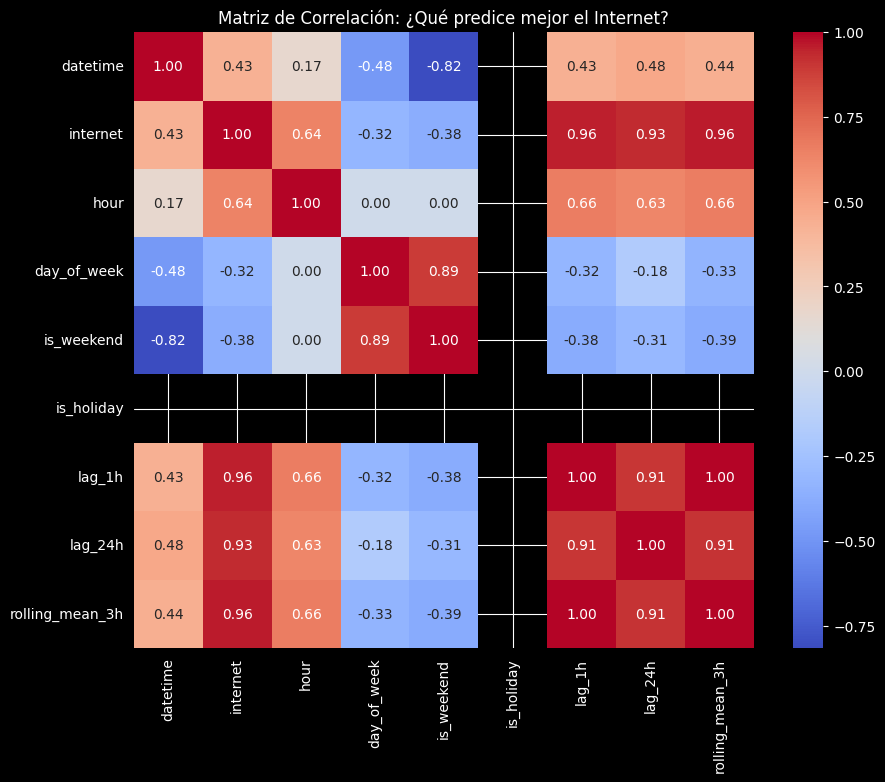

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- IMPORTACIÓN ---
try:
    df = pd.read_pickle("df_clean.pkl")
    print("DataFrame cargado correctamente.")
    print(f"Dimensiones: {df.shape}")
except FileNotFoundError:
    print("⚠ Error: No se encontró el archivo 'df_clean.pkl'. Ejecuta primero el notebook 01.")
# -----------------------
# Asumimos que 'df' es tu DataFrame limpio del paso anterior.
# Si cambiaste de notebook, recárgalo o pasa la variable.

def feature_engineering(df_input):
    df_eng = df_input.copy()

    # 1. Extraer componentes básicos de tiempo
    df_eng['hour'] = df_eng['datetime'].dt.hour
    df_eng['day_of_week'] = df_eng['datetime'].dt.dayofweek # 0=Lunes, 6=Domingo

    # 2. Flag de Fin de Semana (Sábado=5, Domingo=6)
    df_eng['is_weekend'] = df_eng['day_of_week'].isin([5, 6]).astype(int)

    # 3. Flag de Festivo (CRÍTICO para este dataset)
    # Marcamos el 1 de Noviembre como festivo manual
    # En producción usaríamos una librería como 'holidays'
    df_eng['is_holiday'] = 0
    df_eng.loc[df_eng['datetime'].dt.date == pd.to_datetime('2013-11-01').date(), 'is_holiday'] = 1

    return df_eng

def create_lag_features(df_input):
    """
    Crea columnas con el tráfico pasado.
    NOTA: Esto lo haremos sobre el tráfico AGREGADO (total ciudad) primero
    para simplificar el primer modelo.
    """
    # Agrupamos por hora para tener una sola serie temporal de toda la ciudad
    df_total = df_input.groupby('datetime')['internet'].sum().reset_index()
    df_total = feature_engineering(df_total)

    # Lag 1: Tráfico hace 1 hora
    df_total['lag_1h'] = df_total['internet'].shift(1)

    # Lag 24: Tráfico hace 24 horas (Misma hora ayer)
    df_total['lag_24h'] = df_total['internet'].shift(24)

    # Rolling Mean: Promedio de las últimas 3 horas (suavizado)
    df_total['rolling_mean_3h'] = df_total['internet'].rolling(window=3).mean()

    # Eliminamos las filas que quedaron con NaN por los shifts (las primeras 24h)
    df_total.dropna(inplace=True)

    return df_total

# --- EJECUCIÓN ---
print("Generando características...")
df_model_ready = create_lag_features(df)

print("\n--- Dataset Listo para el Modelo ---")
print(df_model_ready.head())

# Verificación de Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_model_ready.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación: ¿Qué predice mejor el Internet?")
plt.show()

In [2]:
# --- EXPORTACIÓN PARA MODELADO ---
# Guardamos el resultado final del preprocesamiento
df_model_ready.to_pickle("df_features.pkl")
print("Dataset procesado guardado en 'df_features.pkl'")

Dataset procesado guardado en 'df_features.pkl'
